## Importing Libraries

In [1]:
from livelossplot.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline

## Load and Preprocess SETI Data

In [2]:
train_images = pd.read_csv('dataset/train/images.csv',header=None)
train_labels = pd.read_csv('dataset/train/labels.csv',header=None)

val_images = pd.read_csv('dataset/validation/images.csv',header=None)
val_labels = pd.read_csv('dataset/validation/labels.csv',header=None)

In [3]:
train_images.head(2)

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490


In [4]:
train_labels.head(2)

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0


In [5]:
print("Training set shape",train_images.shape,train_labels.shape)
print("Validation set shape",val_images.shape,val_labels.shape)

Training set shape (3200, 8192) (3200, 4)
Validation set shape (800, 8192) (800, 4)


In [6]:
x_train = train_images.values.reshape(3200,64,128,1)
x_val   = val_images.values.reshape(800,64,128,1)

y_train = train_labels.values
y_val   = val_labels.values

## Plot the 2D Spectrograms

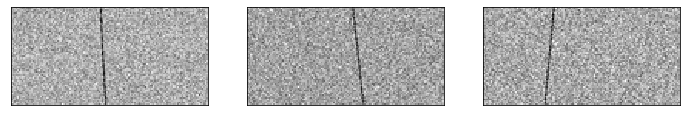

In [7]:
plt.figure(0,figsize=(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = np.squeeze(x_train[np.random.randint(0,x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img,'gray')

## Training and Validation Data Generators

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using Image Augmentation : horizontal flip
datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

##  Creating the CNN Model

In [9]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
model = Sequential()

model.add(Conv2D(32,(5,5),padding='same',input_shape=(64,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(4,activation='softmax'))

In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64)        2

## Learning Rate Scheduling and Compile the Model

In [12]:
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=5, 
    decay_rate=0.96,
    staircase=True
) #lr = lr * (decay_rate ^ decay_steps)
optimizer= Adam(learning_rate=lr_schedule)

In [13]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

## Training the Model

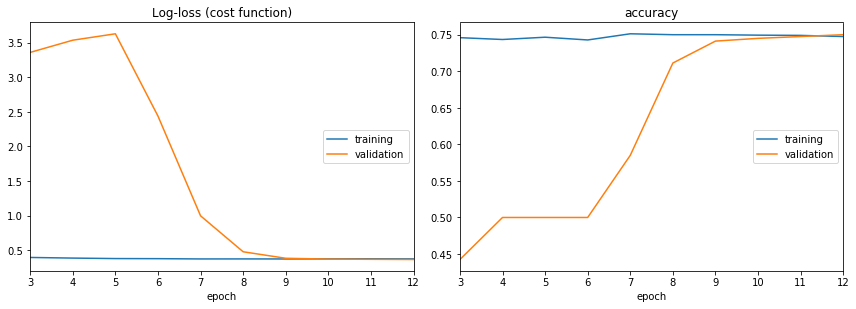

Log-loss (cost function):
training   (min:    0.371, max:    0.736, cur:    0.373)
validation (min:    0.363, max:    3.788, cur:    0.363)

accuracy:
training   (min:    0.665, max:    0.751, cur:    0.748)
validation (min:    0.250, max:    0.750, cur:    0.750)
100/100 [==============================] - 33s 331ms/step - loss: 0.3727 - accuracy: 0.7475 - val_loss: 0.3633 - val_accuracy: 0.7500


In [14]:
checkpoint = ModelCheckpoint('model_weight.h5',monitor='val_loss',
                            save_weights_only=True,mode='min' , verbose=0)
callbacks = [PlotLossesCallback(), checkpoint]

batch_size = 32

history = model.fit(
    datagen_train.flow(x_train,y_train,batch_size=batch_size,shuffle=True),
    steps_per_epoch = len(x_train) // batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size,shuffle=True),
    validation_steps= len(x_val) // batch_size,
    epochs = 12,
    callbacks=callbacks
)

## Evaluation

In [15]:
model.evaluate(x_val,y_val)

800/800 [==============================] - 2s 2ms/sample - loss: 0.3638 - accuracy: 0.7513


[0.363807484631252, 0.75125]

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

#confusion matrix
y_true = np.argmax(y_val,1)
y_pred = np.argmax(model.predict(x_val) , 1)

print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       200
           1       0.62      0.04      0.08       200
           2       0.50      0.97      0.66       200
           3       1.00      1.00      1.00       200

    accuracy                           0.75       800
   macro avg       0.78      0.75      0.68       800
weighted avg       0.78      0.75      0.68       800



In [17]:
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true,y_pred))

Classification accuracy: 0.751250
